In [9]:
import json
from pathlib import Path

import geopandas as gpd
import fiona
import numpy as np
import pandas as pd
import pycountry
import shapely
from shapely.geometry import Point


from climada.util.api_client import Client
from climada.entity import LitPop, ImpactFuncSet, ImpactFunc
from climada.hazard import Hazard
from climada.engine import Impact
from climada.entity import Exposures

from handlers import get_iso3_country_code, generate_exposure_geojson
from logger_config import LoggerConfig

logger = LoggerConfig(logger_types=["file"])


notebook_dir = %pwd

# Go up one directory
BASE_DIR = Path(notebook_dir).parent

# Define the paths for exposures and hazards
DATA_DIR = BASE_DIR / "data"
EXPOSURES_DIR = BASE_DIR / "data" / "exposures"
HAZARDS_DIR = BASE_DIR / "data" / "hazards"
REQUIREMENTS_DIR = BASE_DIR / "requirements"
MAP_DIR = BASE_DIR / "src" / "temp"
GADM41_EGY_PATH = REQUIREMENTS_DIR / "gadm41_EGY.gpkg"
GADM41_THA_PATH = REQUIREMENTS_DIR / "gadm41_THA.gpkg"

# Available Exposure data types in CLIMADA API for Egypt/Thailand: ['litpop']
# Available Hazard data types in CLIMADA API for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
# Available climate scenarios for hazard type river_flood/tropical_c in country Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
# Available time horizons for hazard type river_flood in country Egypt: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']

country_name = "Egypt"
exposure_type = "litpop"        # Available exposure types for Egypt/Thailand: ['litpop']
hazard_type = "river_flood"     # Available hazard types for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
climate_scenario = "rcp26" # Available scenarios for Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
time_horizon = "2030_2050"      # Available time horizons for Egypt/Thailand: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070'] / 


client = Client()

In [5]:
# List DataTypeInfos
data_type_infos = client.list_data_type_infos()
exposure_data_types = [data_type_info.data_type for data_type_info in data_type_infos if data_type_info.data_type_group == 'exposures']
hazard_data_types = [data_type_info.data_type for data_type_info in data_type_infos if data_type_info.data_type_group == 'hazard']

print(f'Available Exposure data types in CLIMADA API for all countries:\n{exposure_data_types}')
print(f'Available Hazard data types in CLIMADA API for all countries:\n{hazard_data_types}')

Available Exposure data types in CLIMADA API for all countries:
['litpop', 'crop_production', 'crops']
Available Hazard data types in CLIMADA API for all countries:
['tropical_cyclone', 'wildfire', 'river_flood', 'storm_europe', 'relative_cropyield', 'earthquake', 'flood', 'hail']


In [64]:
# Available country Exposures and Hazard data types
dataset_infos = client.list_dataset_infos(
    properties={
        'country_name': country_name,
    }
)

exposure_data_types= list(set([dataset_info.data_type.data_type for dataset_info in dataset_infos if dataset_info.data_type.data_type_group == 'exposures']))
hazard_data_types = list(set([dataset_info.data_type.data_type for dataset_info in dataset_infos if dataset_info.data_type.data_type_group == 'hazard']))

print(f'Available Exposure data types in CLIMADA API for {country_name}: {exposure_data_types}')
print(f'Available Hazard data types in CLIMADA API for {country_name}: {hazard_data_types}')

Available Exposure data types in CLIMADA API for Thailand: ['litpop']
Available Hazard data types in CLIMADA API for Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']


In [36]:
if hazard_type == 'river_flood' or 'wildfire':
    available_scenarios = list(set([dataset_info.properties['climate_scenario'] for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
    available_time_horizons = list(set([dataset_info.properties['year_range'] for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
if hazard_type == 'tropical_cyclone':
    available_scenarios = list(set([dataset_info.properties['climate_scenario'] for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
    available_time_horizons = list(set([dataset_info.properties.get('ref_year') for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
if hazard_type == 'earthquake':
    available_scenarios = []
    available_time_horizons = []
if hazard_type == 'flood':
    available_scenarios = []
    available_time_horizons = list(set([dataset_info.properties['year_range'] for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))

print(f'Available climate scenarios for hazard type {hazard_type} in country {country_name}: {available_scenarios}')
print(f'Available time horizons for hazard type {hazard_type} in country {country_name}: {available_time_horizons}')

Available climate scenarios for hazard type river_flood in country Egypt: ['rcp26', 'historical', 'rcp60', 'rcp85']
Available time horizons for hazard type river_flood in country Egypt: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']


In [4]:
# Available country Hazard DatasetInfos
hazard_dataset_infos = client.list_dataset_infos(
    properties={
        'data_type': hazard_type,
        'country_name': country_name,
        'climate_scenario': climate_scenario
    }
)
hazard_dataset_infos

[DatasetInfo(uuid='f3f61cd8-d39b-473c-9acb-fd5bffac52e0', data_type=DataTypeShortInfo(data_type='river_flood', data_type_group='hazard'), name='river_flood_150arcsec_hist_THA_1980_2000', version='v2', status='active', properties={'res_arcsec': '150', 'climate_scenario': 'historical', 'year_range': '1980_2000', 'climada_version': 'v3.1.2', 'spatial_coverage': 'country', 'date_creation': '2022-7-6', 'country_iso3alpha': 'THA', 'country_name': 'Thailand', 'country_iso3num': '764'}, files=[FileInfo(uuid='f3f61cd8-d39b-473c-9acb-fd5bffac52e0', url='https://data.iac.ethz.ch/climada/f3f61cd8-d39b-473c-9acb-fd5bffac52e0/river_flood_150arcsec_hist_THA_1980_2000.hdf5', file_name='river_flood_150arcsec_hist_THA_1980_2000.hdf5', file_format='hdf5', file_size=5679244, check_sum='md5:102d02e170464a1bb15a745edfd8832c')], doi=None, description='Historical CLIMADA flood hazard by country and by 20 year range at a 150 arcsec resolution. The hazard is based on annual spatially explicit flood depth and fl

In [2]:
# Get Exposure and Exposure gdf
# Available Exposures: ['litpop']
exposure = client.get_litpop(
    country=country_name,
    exponents=(1,1),
    dump_dir=EXPOSURES_DIR,
)
exposure_gdf = exposure.gdf
exposure_gdf

,value,geometry,latitude,longitude,region_id,impf_
0,5818.850950,POINT (35.60417 23.10417),23.104167,35.604167,818,1
1,2754.686960,POINT (35.56250 23.06250),23.062500,35.562500,818,1
2,2981.679567,POINT (35.60417 23.06250),23.062500,35.604167,818,1
3,686.425475,POINT (35.64583 23.06250),23.062500,35.645833,818,1
4,611.069759,POINT (35.52083 23.02083),23.020833,35.520833,818,1
...,...,...,...,...,...,...
52118,9120.352229,POINT (34.52083 27.93750),27.937500,34.520833,818,1
52119,15787.142583,POINT (34.56250 27.93750),27.937500,34.562500,818,1
52120,8923.414753,POINT (34.60417 27.93750),27.937500,34.604167,818,1
52121,1943.688900,POINT (33.10417 31.22917),31.229167,33.104167,818,1


In [18]:
# Get Hazard
# Available Hazards: ['river_flood', 'tropical_cyclone', 'wildfire', 'flood', 'earthquake']

hazard = client.get_hazard(
    hazard_type=hazard_type,
    properties={
        "country_name": country_name,
        "climate_scenario": climate_scenario,
        "year_range": time_horizon
    },
    dump_dir=HAZARDS_DIR,
)

if hazard_type == 'river_flood':
    hazard.intensity_thres = 1

<GeoAxesSubplot:title={'center':'RF max intensity at each point'}>

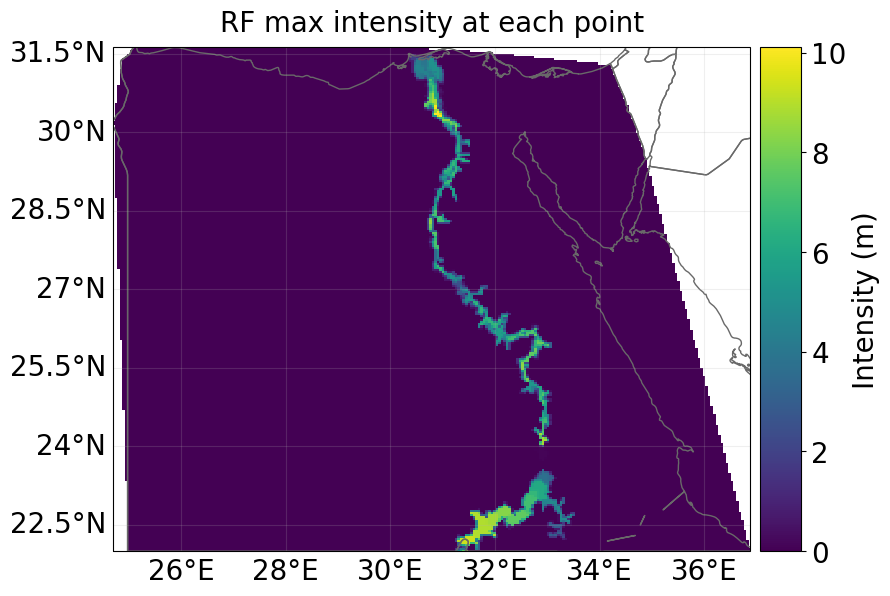

In [12]:
hazard.plot_intensity(0)

(<GeoAxesSubplot:title={'center':'Return period: 25 years'}>,
 array([[0., 0., 0., ..., 0., 0., 0.]]))

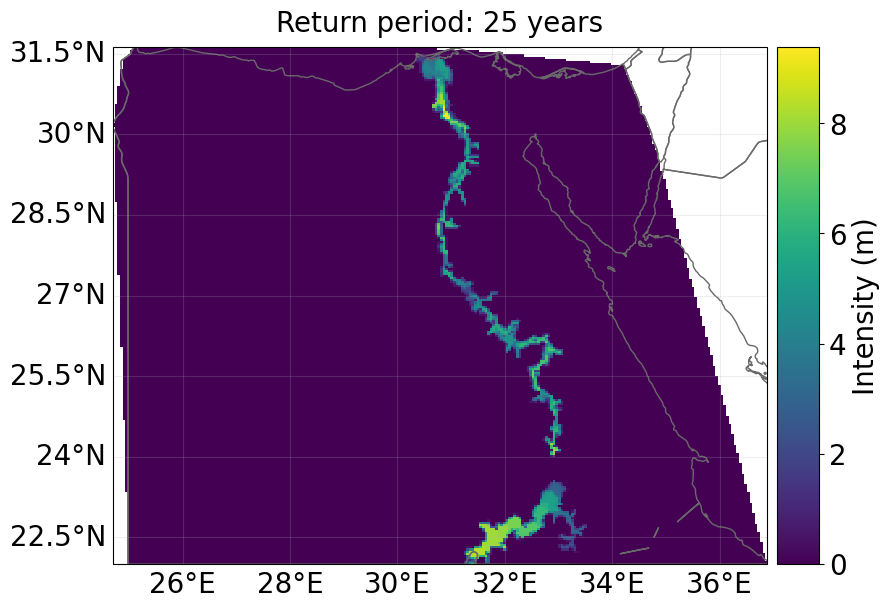

In [17]:
hazard.plot_rp_intensity((25,))

In [19]:
hazard.local_exceedance_inten((250,))

array([[0., 0., 0., ..., 0., 0., 0.]])

In [34]:
def mean_nonzero(series):
    non_zeros = series[series != 0]
    return non_zeros.mean() if not non_zeros.empty else 0


def generate_hazard_geojson(hazard, country_name, return_periods=(250, 100, 50, 10)):
    try:
        country_iso3 = get_iso3_country_code(country_name)
        GADM41_filename = Path(REQUIREMENTS_DIR) / f"gadm41_{country_iso3}.gpkg"
        layers = [0, 1, 2]

        all_layers_geojson = {"type": "FeatureCollection", "features": []}

        for layer in layers:
            admin_gdf = gpd.read_file(filename=GADM41_filename, layer=layer)

            country_iso3 = get_iso3_country_code(country_name)
            GADM41_filename = Path(REQUIREMENTS_DIR) / f"gadm41_{country_iso3}.gpkg"
            admin_gdf = gpd.read_file(filename=GADM41_filename, layer=layer)
            # Assuming hazard.centroids.coord gives a list of [longitude, latitude]
            coords = np.array(hazard.centroids.coord)
            local_exceedance_inten = hazard.local_exceedance_inten(return_periods)
            local_exceedance_inten = pd.DataFrame(local_exceedance_inten).T
            data = np.column_stack((coords, local_exceedance_inten))
            columns = ["longitude", "latitude"] + [f"rp{rp}" for rp in return_periods]
            hazard_gdf = gpd.GeoDataFrame(
                pd.DataFrame(data, columns=columns),
                geometry=gpd.points_from_xy(data[:, 0], data[:, 1]),
            )
            hazard_gdf.set_crs("EPSG:4326", inplace=True)

            # Spatial join with administrative areas
            joined_gdf = gpd.sjoin(hazard_gdf, admin_gdf, how="left", predicate="within")

            # Aggregating non-zero mean values for each administrative area
            agg_dict = {f"rp{rp}": mean_nonzero for rp in return_periods}

            # Aggregated GeoDataFrame for this layer
            aggregated_gdf = joined_gdf.groupby(f"GID_{layer}").agg(agg_dict)
            aggregated_gdf = aggregated_gdf.merge(
                admin_gdf[[f"GID_{layer}", "geometry"]], on=f"GID_{layer}"
            )

            # Convert to GeoJSON for this layer and add to all_layers_geojson
            layer_geojson = gpd.GeoDataFrame(aggregated_gdf).__geo_interface__
            for feature in layer_geojson["features"]:
                feature["properties"]["layer"] = layer
                all_layers_geojson["features"].append(feature)

        # Save the combined GeoJSON file
        map_data_filepath = MAP_DIR / f"hazards_geodata.json"
        with open(map_data_filepath, "w") as f:
            json.dump(all_layers_geojson, f)
    except Exception as e:
        logger.log("debug", f"An unexpected error occurred: {e}")


generate_hazard_geojson(hazard, country_name)

In [110]:
country_iso3 = get_iso3_country_code(country_name)
GADM41_filename = Path(REQUIREMENTS_DIR) / f"gadm41_{country_iso3}.gpkg"
admin_gdf = gpd.read_file(filename=GADM41_filename, layer=layer)
admin_gdf

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,EGY.1_1,EGY,Egypt,Ad Daqahliyah,Al Daqahliyah|Dacahlia|Dagahlia|,الدقهلية,Muhafazah,Governorate,NA,EG.DQ,EG-DK,"MULTIPOLYGON (((31.37191 30.75982, 31.36459 30..."
1,EGY.2_1,EGY,Egypt,Al Bahr al Ahmar,Mar Rojo|Mar Vermelho|Mer Rouge|,محافظة البحر الأحمر,Muhafazah,Governorate,NA,EG.BA,EG-BA,"MULTIPOLYGON (((35.47458 24.14069, 35.47458 24..."
2,EGY.3_1,EGY,Egypt,Al Buhayrah,Beheira|Behera|El Buhayra|Béhéra,البحيرة,Muhafazah,Governorate,NA,EG.BH,EG-BH,"MULTIPOLYGON (((30.52893 30.47858, 30.48588 30..."
3,EGY.4_1,EGY,Egypt,Al Fayyum,El Faiyum|el Fayoum|Faium|Faiyūm,محافظة الفيوم,Muhafazah,Governorate,NA,EG.FY,EG-FYM,"MULTIPOLYGON (((30.94840 29.20572, 30.94753 29..."
4,EGY.5_1,EGY,Egypt,Al Gharbiyah,al-Garbīyah|El Gharbiya|Garbia|G,محافظة الغربية,Muhafazah,Governorate,NA,EG.GH,EG-GH,"MULTIPOLYGON (((31.23971 31.05595, 31.25710 31..."
5,EGY.6_1,EGY,Egypt,Al Iskandariyah,Alexandria|Alexandrie|El Iskanda,محافظة الإسكندرية,Muhafazah,Governorate,NA,EG.IK,EG-ALX,"MULTIPOLYGON (((29.63280 30.26276, 29.63277 30..."
6,EGY.7_1,EGY,Egypt,Al Isma`iliyah,As Ismailiyah|Ismailia|Ismaïlia|,محافظة الإسماعيلية,Muhafazah,Governorate,NA,EG.IS,NA,"MULTIPOLYGON (((31.79850 30.48218, 31.82200 30..."
7,EGY.8_1,EGY,Egypt,Al Jizah,El Giza|El Gīzah|Gizeh|Giza|Guiz,NA,Muhafazah,Governorate,NA,EG.JZ,EG-GZ,"MULTIPOLYGON (((30.64093 30.17111, 30.64258 30..."
8,EGY.9_1,EGY,Egypt,Al Minufiyah,Menoufieh|Menufia|Menūfīya|Minūf,محافظة المنوفية,Muhafazah,Governorate,NA,EG.MF,EG-MNF,"MULTIPOLYGON (((31.04201 30.20961, 31.03384 30..."
9,EGY.10_1,EGY,Egypt,Al Minya,Minia|Minieh|Menia|Minya,NA,Muhafazah,Governorate,NA,EG.MN,EG-MN,"MULTIPOLYGON (((30.85316 27.60245, 30.84006 27..."


In [32]:
# Calculate Impact

hazard.intensity_thres = 1
impact_function = ImpactFunc()
impact_function.haz_type = "RF"
impact_function.intensity_unit = "m"
impact_function.id = 3
impact_function.name = "Flood Europe JRC Residential"
impact_function.intensity = np.array(
    [0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 12.0]
)
impact_function.mdd = np.array(
    [0.00, 0.25, 0.40, 0.50, 0.60, 0.75, 0.85, 0.95, 1.00, 1.00]
)
impact_function.mdr = np.array(
    [0.000, 0.250, 0.400, 0.500, 0.600, 0.750, 0.850, 0.950, 1.000, 1.000]
)
impact_function.paa = np.ones(len(impact_function.intensity))
impact_function_set = ImpactFuncSet()
# impact_function_set = ImpactFuncSet([impact_function])
impf_id = 3

impact_function_set.append(impact_function)
exposure.gdf[f"impf_{impact_function.haz_type}"] = impf_id
exposure.impact_funcs#s = impact_function_set
impact = Impact()
impact.calc(exposure, impact_function_set, hazard, save_mat=True)

impact
# impact_function_set.check()

2023-11-21 12:26:06,024 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
